# LSTM Stock Predictor Using Closing Prices

## Data Preparation

In this section, we will prepare the training and testing data for the LSTM model.

We will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the `X` and `y` values
4. Reshape the `X_train` and `X_test` data for the model.

**Note:** The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [2]:
# Initial imports
import numpy as np
import pandas as pd
from pathlib import Path

%matplotlib inline

In [3]:
# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

ModuleNotFoundError: No module named 'tensorflow'

### Data Loading

In [4]:
# Load the features data as X
feat = pd.read_csv('features.csv',index_col=0, parse_dates=True, infer_datetime_format=True)
# Load the Target data as X
CS = pd.read_csv('CS.csv',index_col=0, parse_dates=True, infer_datetime_format=True)

In [5]:
CS = pd.read_csv('CS.csv',index_col=0, parse_dates=True, infer_datetime_format=True)
CS = CS.resample('Q').last()
CS = CS.iloc[:-1]
CS.shape

(137, 1)

In [6]:
# Load features in DF
feat = pd.read_csv('features.csv',index_col=0, parse_dates=True, infer_datetime_format=True)
feat = feat.loc[CS.index[0]:CS.index[-1]]
feat.shape

(137, 9)

In [ ]:
df = pd.concat([feat,CS],axis='columns')
df.head()

### Creating the Features `X` and Target `y` Data

The first step towards preparing the data is to create the input features vectors `X` and the target vector `y`. We will use the `window_data()` function to create these vectors.

This function chunks the data up with a rolling window of _X<sub>t</sub> - window_ to predict _X<sub>t</sub>_.

The function returns two `numpy` arrays:

* `X`: The input features vectors.

* `y`: The target vector.

The function has the following parameters:

* `df`: The original DataFrame with the time series data.

* `window`: The window size in days (- quarters?-) of previous closing prices that will be used for the prediction.

* `feature_col_number`: The column number from the original DataFrame where the features are located.

* `target_col_number`: The column number from the original DataFrame where the target is located.

In [ ]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In the forthcoming activities, we will predict closing prices using a `5` days windows of previous _T-Bonds_ closing prices, so that, we will create the `X` and `y` vectors by calling the `window_data` function and defining a window size of `5` and setting the features and target column numbers to `2` (this is the column with the _T-Bonds_ closing prices).

In [ ]:
# Creating the features (X) and target (y) data using the window_data() function.
# setting window_size as 120 quarters
window_size = 5

feature_column = list(range(9))
target_column = 9
X, y = window_data(df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

### Splitting Data Between Training and Testing Sets

To avoid the dataset being randomized, we will manually split the data using array slicing.

In [ ]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

### Scaling Data with `MinMaxScaler`

Once the training and test datasets are created, we need to scale the data before training the LSTM model. We will use the `MinMaxScaler` from `sklearn` to scale all values between `0` and `1`.

Note that we scale both features and target sets.

In [ ]:
X.shape

In [ ]:
# # Use the MinMaxScaler to scale data between 0 and 1.
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# scaler.fit(X)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
# scaler.fit(y)
# y_train = scaler.transform(y_train)
# y_test = scaler.transform(y_test)

### Reshape Features Data for the LSTM Model

The LSTM API from Keras needs to receive the features data as a _vertical vector_, so that we need to reshape the `X` data in the form `reshape((X_train.shape[0], X_train.shape[1], 1))`.

Both sets, training, and testing are reshaped.

In [ ]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

---

## Build and Train the LSTM RNN

In this section, we will design a custom LSTM RNN in Keras and fit (train) it using the training data we defined.

We will need to:

1. Define the model architecture in Keras.

2. Compile the model.

3. Fit the model to the training data.

### Importing the Keras Modules

The LSTM RNN model in Keras uses the `Sequential` model and the `LSTM` layer as we did before. However, there is a new type of layer called `Dropout`.

* `Dropout`: Dropout is a regularization technique for reducing overfitting in neural networks. This type of layer applies the dropout technique to the input.

In [ ]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

### Defining the LSTM RNN Model Structure

To create an LSTM RNN model, we will add `LSTM` layers. The `return_sequences` parameter needs to set to `True` every time we add a new `LSTM` layer, excluding the final layer. The `input_shape` is the number of time steps and the number of indicators

After each `LSTM` layer, we add a `Dropout` layer to prevent overfitting. The parameter passed to the `Dropout` layer is the fraction of nodes that will be drop on each epoch, for this demo, we will use a dropout value of `0.2`, it means that on each epoch we will randomly drop `20%` of the units.

The number of units in each `LSTM` layers, is equal to the size of the time window, in this demo, we are taking five previous `T-Bons` closing price to predict the next closing price.

In [ ]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

### Compiling the LSTM RNN Model

We will compile the model, using the `adam` optimizer, as loss function, we will use `mean_square_error` since the value we want to predict is continuous.

In [ ]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
# Summarize the model
model.summary()

### Training the Model

Once the model is defined, we train (fit) the model using `10` epochs. Since we are working with time-series data, it's important to set `shuffle=False` since it's necessary to keep the sequential order of the data.

We can experiment with the `batch_size` parameter; however, smaller batch size is recommended; in this demo, we will use a `batch_size=1`.

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=35000, shuffle=False, batch_size=1000, verbose=1)

Epoch 1/100000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-07-22 21:21:24.760938: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-07-22 21:21:24.761083: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 205ms/step - loss: 14332.4590
Epoch 2/100000
1/1 [==============================] - 0s 12ms/step - loss: 14331.2744
Epoch 3/100000
1/1 [==============================] - 0s 8ms/step - loss: 14320.9619
Epoch 4/100000
1/1 [==============================] - 0s 15ms/step - loss: 14324.5947
Epoch 5/100000
1/1 [==============================] - 0s 14ms/step - loss: 14313.4404
Epoch 6/100000
1/1 [==============================] - 0s 8ms/step - loss: 14313.4033
Epoch 7/100000
1/1 [==============================] - 0s 9ms/step - loss: 14311.4697
Epoch 8/100000
1/1 [==============================] - 0s 9ms/step - loss: 14305.7607
Epoch 9/100000
1/1 [==============================] - 0s 8ms/step - loss: 14301.3955
Epoch 10/100000
1/1 [==============================] - 0s 10ms/step - loss: 14301.0273
Epoch 11/100000
1/1 [==============================] - 0s 9ms/step - loss: 14294.3613
Epoch 12/100000
1/1 [==============================] - 0s 9ms/step - los

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 9ms/step - loss: 1856.0031
Epoch 44074/100000
1/1 [==============================] - 0s 8ms/step - loss: 1882.4344
Epoch 44075/100000
1/1 [==============================] - 0s 8ms/step - loss: 1694.7770
Epoch 44076/100000
1/1 [==============================] - 0s 9ms/step - loss: 1733.5490
Epoch 44077/100000
1/1 [==============================] - 0s 8ms/step - loss: 1628.6818
Epoch 44078/100000
1/1 [==============================] - 0s 9ms/step - loss: 1797.4344
Epoch 44079/100000
1/1 [==============================] - 0s 9ms/step - loss: 1852.2844
Epoch 44080/100000
1/1 [==============================] - 0s 9ms/step - loss: 1652.8971
Epoch 44081/100000
1/1 [==============================] - 0s 9ms/step - loss: 1490.5312
Epoch 44082/100000
1/1 [==============================] - 0s 9ms/step - loss: 1405.5244
Epoch 44083/100000
1/1 [==============================] - 0s 8ms/step - loss: 1825.6792
Epoch 44084/100000
1/1 [===========================

---
## Model Performance

In this section, we will evaluate the model using the test data.

We will need to:

1. Evaluate the model using the `X_test` and `y_test` data.

2. Use the `X_test` data to make predictions.

3. Create a DataFrame of real (`y_test`) vs predicted values.

4. Plot the Real vs predicted values as a line chart.

### Evaluate the Model

It's time to evaluate our model to assess its performance. We will use the `evaluate` method using the testing data.

In [1]:
# Evaluate the model
model.evaluate(X_test, y_test)

NameError: name 'model' is not defined

### Making Predictions

We will make some closing price predictions using our brand new LSTM RNN model and our testing data.

In [25]:
# Make some predictions
predicted = model.predict(X_test)

Since we scaled the original values using the `MinMaxScaler`, we need to recover the original prices to better understand the predictions.

We will use the `inverse_transform()` method of the scaler to decode the scaled values to their original scale.

In [ ]:
# # Recover the original prices instead of the scaled version
# predicted_prices = scaler.inverse_transform(predicted)
# real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [26]:
predicted_prices = predicted
real_prices = y_test.reshape(-1, 1)

### Plotting Predicted Vs. Real Prices

To plot the predicted vs. the real values, we will create a DataFrame.

In [27]:
# Create a DataFrame of Real and Predicted values
CS_prediction = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])
CS_prediction.head()

,Real,Predicted
2011-06-30,141.946,112.385239
2011-09-30,140.169,112.385239
2011-12-31,135.167,112.385239
2012-03-31,135.871,112.385239
2012-06-30,143.174,112.385239


<AxesSubplot:>

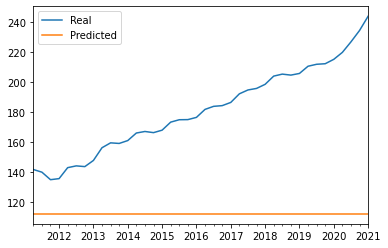

In [28]:
# Plot the real vs predicted prices as a line chart
CS_prediction.plot()